In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#### Dataset Link: https://www.kaggle.com/datasets/anu0012/hotel-review?select=train.csv

In [2]:
df = pd.read_csv("datasets/train.csv")

df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [3]:
# Check the info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       38932 non-null  object
 1   Description   38932 non-null  object
 2   Browser_Used  38932 non-null  object
 3   Device_Used   38932 non-null  object
 4   Is_Response   38932 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [4]:
# Check the shape

df.shape

(38932, 5)

In [5]:
# Check the null value

df.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

In [6]:
# Check the duplicated values

df.duplicated().sum()

0

In [7]:
df.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id10326,The room was kind of clean but had a VERY stro...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [8]:
df.describe().transpose()

,count,unique,top,freq
User_ID,38932,38932,id10326,1
Description,38932,38932,The room was kind of clean but had a VERY stro...,1
Browser_Used,38932,11,Firefox,7367
Device_Used,38932,3,Desktop,15026
Is_Response,38932,2,happy,26521


## Data Cleaning and EDA

In [9]:
### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

total_null_count = df.isnull().sum().sort_values(ascending=False)

percentage = ((df.isnull().sum() / len(df) * 100 )).sort_values(ascending=False)

missing_data = pd.concat(objs=[total_null_count, percentage], axis=1, keys=['Total Null count', 'Percentage'])

missing_data

,Total Null count,Percentage
User_ID,0,0.0
Description,0,0.0
Browser_Used,0,0.0
Device_Used,0,0.0
Is_Response,0,0.0


In [10]:
# Check the dataset is balence or not

df['Is_Response'].value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

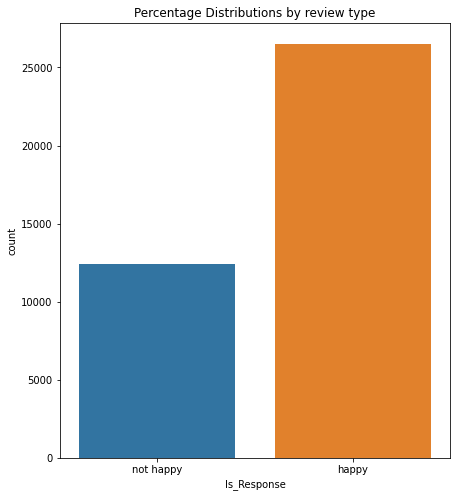

In [11]:
### Checking for the Distribution of Is_response column ###

plt.figure(figsize=(7,8))
sns.countplot(x='Is_Response', data=df)
plt.title('Percentage Distributions by review type')
plt.show()

Percentage for default

happy        68.12
not happy    31.88
Name: Is_Response, dtype: float64


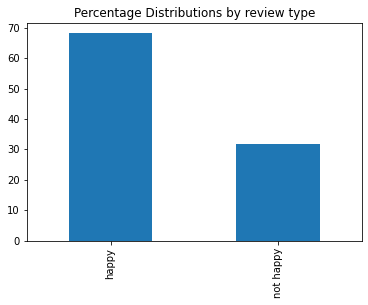

In [12]:
print('Percentage for default\n')

print(round(df.Is_Response.value_counts(normalize=True)*100, 2))

round(df.Is_Response.value_counts(normalize=True)*100, 2).plot(kind='bar')

plt.title('Percentage Distributions by review type')

plt.show()

In [13]:
# Remove unnecessary columns

df.drop(columns=['User_ID', 'Browser_Used', 'Device_Used'], inplace=True)

In [14]:
df.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,not happy
1,I stayed at the Crown Plaza April -- - April -...,not happy
2,I booked this hotel through Hotwire at the low...,not happy
3,Stayed here with husband and sons on the way t...,happy
4,My girlfriends and I stayed here to celebrate ...,not happy


In [15]:
df.loc[0, 'Description']

"The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Breakfast was free and just about better than nothing."

In [16]:
df.iloc[1, 0]

"I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did not work. I encountered some staff in the elevator one evening and I mentioned the ice machine to them. Severel hours later a maid appeared at my door with ice and two mints. I'm not sure how they knew what room I was in. That was a little unnervi

In [17]:
# Handeling contractions words

def expand_contractions_words(text):
    text = contractions.fix(s=text)
    return text

In [18]:
df['Description'] = df['Description'].apply(func=expand_contractions_words)

In [19]:
df.iloc[1, 0]

"I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did not work. I encountered some staff in the elevator one evening and I mentioned the ice machine to them. Severel hours later a maid appeared at my door with ice and two mints. I am not sure how they knew what room I was in. That was a little unnerv

In [20]:
# This functoin will remove all the punctuation, white-space, digits

def text_clean_part1(text):
    text = text.lower()
    text = re.sub(pattern=r"[^a-zA-Z]", repl=' ', string=text)
    text = " ".join(text.split())
    
    return text

In [21]:
# Demo test

text_clean_part1(text=df.iloc[1, 0])

# Demo test end

'i stayed at the crown plaza april april the staff was friendly and attentive the elevators are tiny about by the food in the restaurant was delicious but priced a little on the high side of course this is washington dc there is no pool and little for children to do my room on the fifth floor had two comfortable beds and plenty of space for one person the tv is a little small by todays standards with a limited number of channels there was a small bit of mold in the bathtub area that could have been removed with a little bleach it appeared the carpets were not vacummed every day i reported a light bulb was burned out it was never replaced ice machines are on the odd numbered floors but the one on my floor did not work i encountered some staff in the elevator one evening and i mentioned the ice machine to them severel hours later a maid appeared at my door with ice and two mints i am not sure how they knew what room i was in that was a little unnerving i would stay here again for busines

In [22]:
# Now apply to the entire dataset

df['cleanDescription'] = df['Description'].apply(func=text_clean_part1)

In [23]:
df.head(20)

,Description,Is_Response,cleanDescription
0,The room was kind of clean but had a VERY stro...,not happy,the room was kind of clean but had a very stro...
1,I stayed at the Crown Plaza April -- - April -...,not happy,i stayed at the crown plaza april april the st...
2,I booked this hotel through Hotwire at the low...,not happy,i booked this hotel through hotwire at the low...
3,Stayed here with husband and sons on the way t...,happy,stayed here with husband and sons on the way t...
4,My girlfriends and I stayed here to celebrate ...,not happy,my girlfriends and i stayed here to celebrate ...
5,We had - rooms. One was very nice and clearly ...,happy,we had rooms one was very nice and clearly had...
6,My husband and I have stayed in this hotel a f...,not happy,my husband and i have stayed in this hotel a f...
7,My wife & I stayed in this glorious city a whi...,happy,my wife i stayed in this glorious city a while...
8,My boyfriend and I stayed at the Fairmont on a...,happy,my boyfriend and i stayed at the fairmont on a...
9,"Wonderful staff, great location, but it was de...",not happy,wonderful staff great location but it was defi...


#### I am not apply PorterStemmer and remove stopwords. It will take much more time.

In [24]:
# Remove stopwords and apply stemming

# ps = PorterStemmer()

# def text_clean_part2(text):
#     words = word_tokenize(text=text)
#     words = [ps.stem(word=word) for word in words if word not in stopwords.words("english")]
#     text = " ".join(words)

#     return text

In [25]:
# df['cleanDescription'] = df['cleanDescription'].apply(func=text_clean_part2)

In [26]:
# Drop the old Description column

df.drop(labels=['Description'], axis=1, inplace=True)

In [27]:
df.head()

,Is_Response,cleanDescription
0,not happy,the room was kind of clean but had a very stro...
1,not happy,i stayed at the crown plaza april april the st...
2,not happy,i booked this hotel through hotwire at the low...
3,happy,stayed here with husband and sons on the way t...
4,not happy,my girlfriends and i stayed here to celebrate ...


## Model training

In [28]:
# Split the dataset into dependent and independent variable

independent_variable = df['cleanDescription']

dependent_variable = df['Is_Response']

In [29]:
encoder = LabelEncoder()

In [30]:
dependent_variable = encoder.fit_transform(y=dependent_variable)
dependent_variable

array([1, 1, 1, ..., 1, 1, 0])

In [31]:
encoder.classes_

array(['happy', 'not happy'], dtype=object)

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(independent_variable, dependent_variable, test_size=0.25, random_state=2)

In [33]:
print('Xtrain :', len(xtrain))
print('Xtest  :', len(xtest))
print('Ytrain :', len(ytrain))
print('Ytest  :', len(ytest))

Xtrain : 29199
Xtest  : 9733
Ytrain : 29199
Ytest  : 9733


In [34]:
type(xtrain)

pandas.core.series.Series

In [35]:
tf_idf = TfidfVectorizer()

In [36]:
mnnb = MultinomialNB()

## Using Pipeline way

In [37]:
pipeline_model = Pipeline(steps=[
    ('if_idf', tf_idf),
    ('mnnb', mnnb)
])

In [38]:
pipeline_model.fit(X=xtrain, y=ytrain)

Pipeline(steps=[('if_idf', TfidfVectorizer()), ('mnnb', MultinomialNB())])

In [39]:
pipeline_predict = pipeline_model.predict(X=xtest)
pipeline_predict

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
confusion_matrix(y_true=ytest, y_pred=pipeline_predict)

array([[6628,   53],
       [1936, 1116]], dtype=int64)

In [41]:
pipeline_model.score(X=xtest, y=ytest)

0.7956436864276174

## Without Pipeline used

In [42]:
# Split the dataset into dependent and independent variable

X = df['cleanDescription']

y = df['Is_Response']

In [43]:
y = encoder.fit_transform(y=y)
y

array([1, 1, 1, ..., 1, 1, 0])

In [44]:
encoder.classes_

array(['happy', 'not happy'], dtype=object)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [46]:
print('Xtrain :', len(x_train))
print('Xtest  :', len(x_test))
print('Ytrain :', len(y_train))
print('Ytest  :', len(y_test))

Xtrain : 29199
Xtest  : 9733
Ytrain : 29199
Ytest  : 9733


In [47]:
without_pipeline_tf_idf = TfidfVectorizer(max_features=5000)

In [48]:
x_train_tfidf = without_pipeline_tf_idf.fit_transform(raw_documents=x_train).toarray()

x_test_tfidf = without_pipeline_tf_idf.transform(raw_documents=x_test).toarray()

In [49]:
x_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
x_train_tfidf.shape

(29199, 5000)

In [51]:
without_pipeline_tf_idf.get_feature_names_out()

array(['aaa', 'abandoned', 'ability', ..., 'zero', 'zone', 'zoo'],
      dtype=object)

In [52]:
without_pipeline_tf_idf.vocabulary_

{'we': 4837,
 'booked': 518,
 'night': 2912,
 'here': 2071,
 'last': 2442,
 'minute': 2776,
 'as': 258,
 'the': 4419,
 'hotel': 2157,
 'were': 4865,
 'staying': 4194,
 'in': 2229,
 'austin': 307,
 'was': 4816,
 'and': 163,
 'thought': 4449,
 'san': 3772,
 'antonio': 182,
 'might': 2753,
 'be': 398,
 'more': 2814,
 'tourist': 4519,
 'friendly': 1805,
 'not': 2943,
 'disappointed': 1277,
 'this': 4444,
 'place': 3240,
 'is': 2315,
 'rooms': 3725,
 'are': 233,
 'lovely': 2590,
 'big': 464,
 'clean': 823,
 'beds': 420,
 'bathroom': 390,
 'large': 2437,
 'with': 4922,
 'everything': 1527,
 'you': 4985,
 'need': 2874,
 'despite': 1232,
 'being': 435,
 'near': 2866,
 'road': 3705,
 'it': 2321,
 'quiet': 3450,
 'at': 284,
 'breakfast': 556,
 'room': 3724,
 'immaculate': 2209,
 'food': 1747,
 'fresh': 1792,
 'kept': 2373,
 'topped': 4507,
 'up': 4678,
 'great': 1937,
 'location': 2551,
 'free': 1782,
 'parking': 3131,
 'min': 2763,
 'walk': 4789,
 'to': 4485,
 'shopping': 3927,
 'centre': 721,


In [53]:
len(without_pipeline_tf_idf.vocabulary_)

5000

In [54]:
mnnb.fit(X=x_train_tfidf, y=y_train)

MultinomialNB()

In [55]:
y_predict = mnnb.predict(X=x_test_tfidf)
y_predict

array([0, 0, 1, ..., 1, 0, 1])

In [56]:
y_test

array([0, 0, 1, ..., 1, 1, 1])

In [57]:
confusion_matrix(y_true=y_test, y_pred=y_predict)

array([[6304,  281],
       [1143, 2005]], dtype=int64)

In [58]:
accuracy_score(y_true=y_test, y_pred=y_predict)

0.8536936196445084